## Load the Data: The data is loaded from the Excel file using pandas.
Code aiming to understanding the progression from MGUS to sMM to MM based on proteomic data from 16 MGUS, 12 sMM and 16 MM patients

In [40]:
import pandas as pd

# Load the Excel file
# file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/Proteomic_data_testing.xlsx' # All proteomic data
file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_44_65.xlsx' # Minibatch of strict statistical significance 16,12,16
# file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_43_65.xlsx' # Minibatch of strict statistical significance, removing MM03 Change labels below
# file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_44_1205.xlsx' # Minibatch of statistical significance
# data = pd.read_excel(file_path)
data = pd.read_excel(file_path, decimal=',', header=1)

# Display the first few rows of the dataframe to understand its structure
print(data.head())


   Q9NX38  ABITM_HUMAN ABITRAM  \
0  P02768   ALBU_HUMAN     ALB   
1  Q13510  ASAH1_HUMAN   ASAH1   
2  P20160   CAP7_HUMAN    AZU1   
3  P51572  BAP31_HUMAN  BCAP31   
4  Q10588   BST1_HUMAN    BST1   

  Protein Abitram (Actin-binding transcription modulator) (Protein Simiate)  \
0                                            Albumin                          
1  Acid ceramidase (AC) (ACDase) (Acid CDase) (EC...                          
2  Azurocidin (Cationic antimicrobial protein CAP...                          
3  B-cell receptor-associated protein 31 (BCR-ass...                          
4  ADP-ribosyl cyclase/cyclic ADP-ribose hydrolas...                          

   0.173013  0.173012591324241.1   1.961798  0.173012591324241.2  1.977644  \
0  9.370437             9.876080  10.783491             9.877513  8.986333   
1  6.300671             6.313662   6.129214             7.295280  6.106794   
2  8.215985             8.044048   8.541952             8.627567  8.684919   
3  5.571

## Step 2: Preprocess the Data

In [41]:
# Extract features and labels
# The first 4 columns are metadata, the rest are the proteomic data
metadata_cols = ['Accession_ID', 'Gene_Names', 'Gene_Symbol', 'Protein_Description']
feature_cols = data.columns[len(metadata_cols):]
features = data[feature_cols].values

# Create labels for the stages
# First 16 columns are MGUS, next 12 are sMM, last 16 are MM
# labels = [0] * 16 + [1] * 12 + [2] * 15  # removing patient MM03, accuracy 0,77
labels = [0] * 16 + [1] * 12 + [2] * 16
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.T, labels, test_size=0.2, random_state=4)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Step 3: Train a Machine Learning Models (Starting with NN)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SophisticatedNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SophisticatedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)  # Apply softmax activation along the second dimension
        return x

# Model parameters
input_dim = X_train.shape[1]
output_dim = 3  # Number of classes: MGUS, sMM, MM

# Initialize the model
model = SophisticatedNN(input_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy:.4f}')
# Final evaluation on the test set



print(f"Final Test Accuracy: {accuracy:.2f}%")

C:\Users\a121160\AppData\Local\Temp\ipykernel_20360\1299385320.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\a121160\AppData\Local\Temp\ipykernel_20360\1299385320.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\a121160\AppData\Local\Temp\ipykernel_20360\1299385320.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
C:\Users\a121160\AppData\Local\Temp\ipyker

Epoch [10/1000], Loss: 0.9067
Epoch [20/1000], Loss: 0.8024
Epoch [30/1000], Loss: 0.6905
Epoch [40/1000], Loss: 0.6551
Epoch [50/1000], Loss: 0.6179
Epoch [60/1000], Loss: 0.5916
Epoch [70/1000], Loss: 0.5765
Epoch [80/1000], Loss: 0.5711
Epoch [90/1000], Loss: 0.5727
Epoch [100/1000], Loss: 0.5668
Epoch [110/1000], Loss: 0.5701
Epoch [120/1000], Loss: 0.5595
Epoch [130/1000], Loss: 0.5600
Epoch [140/1000], Loss: 0.5613
Epoch [150/1000], Loss: 0.5604
Epoch [160/1000], Loss: 0.5562
Epoch [170/1000], Loss: 0.5580
Epoch [180/1000], Loss: 0.5563
Epoch [190/1000], Loss: 0.5572
Epoch [200/1000], Loss: 0.5573
Epoch [210/1000], Loss: 0.5583
Epoch [220/1000], Loss: 0.5553
Epoch [230/1000], Loss: 0.5555
Epoch [240/1000], Loss: 0.5545
Epoch [250/1000], Loss: 0.5543
Epoch [260/1000], Loss: 0.5531
Epoch [270/1000], Loss: 0.5550
Epoch [280/1000], Loss: 0.5538
Epoch [290/1000], Loss: 0.5537
Epoch [300/1000], Loss: 0.5543
Epoch [310/1000], Loss: 0.5578
Epoch [320/1000], Loss: 0.5543
Epoch [330/1000],

## Visualization 
These plots will help to understand how well the model is performing and visualize the distribution of predictions relative to the actual labels.

Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Plot Training Loss Over Epochs

In [48]:
# First, we'll modify the training loop to store the loss values for each epoch
# Training loop with loss recording
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.5516
Epoch [20/100], Loss: 0.5518
Epoch [30/100], Loss: 0.5516
Epoch [40/100], Loss: 0.5516
Epoch [50/100], Loss: 0.5515
Epoch [60/100], Loss: 0.5516
Epoch [70/100], Loss: 0.5518
Epoch [80/100], Loss: 0.5515
Epoch [90/100], Loss: 0.5518
Epoch [100/100], Loss: 0.5520


Pplot the training loss over epochs.

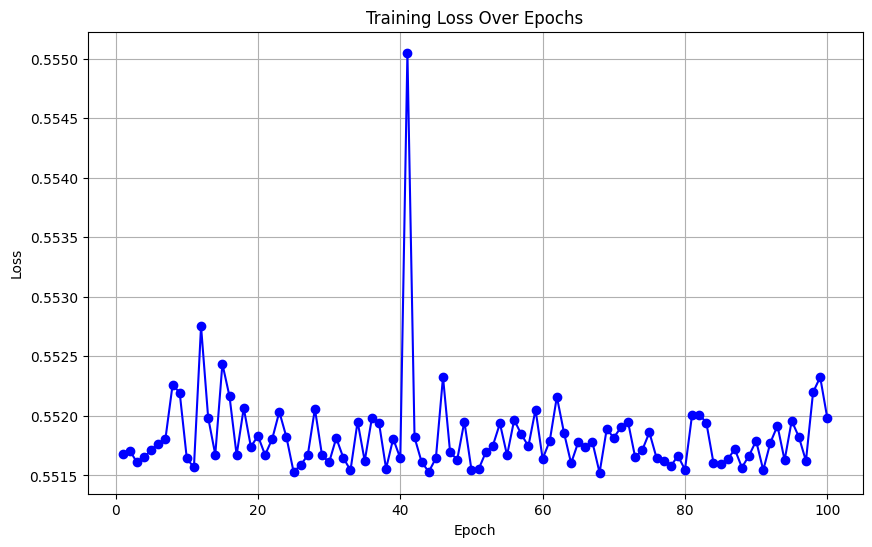

In [49]:
# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Plot Confusion Matrix

<Figure size 800x600 with 0 Axes>

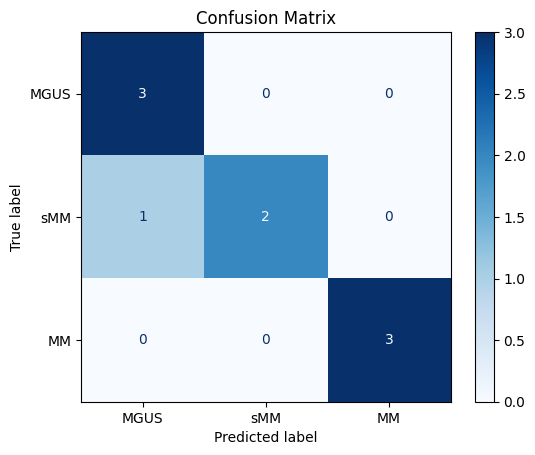

In [50]:
# Evaluation for confusion matrix
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(y_test, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MGUS', 'sMM', 'MM'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Plot Distribution of Predictions vs. Actual Labels

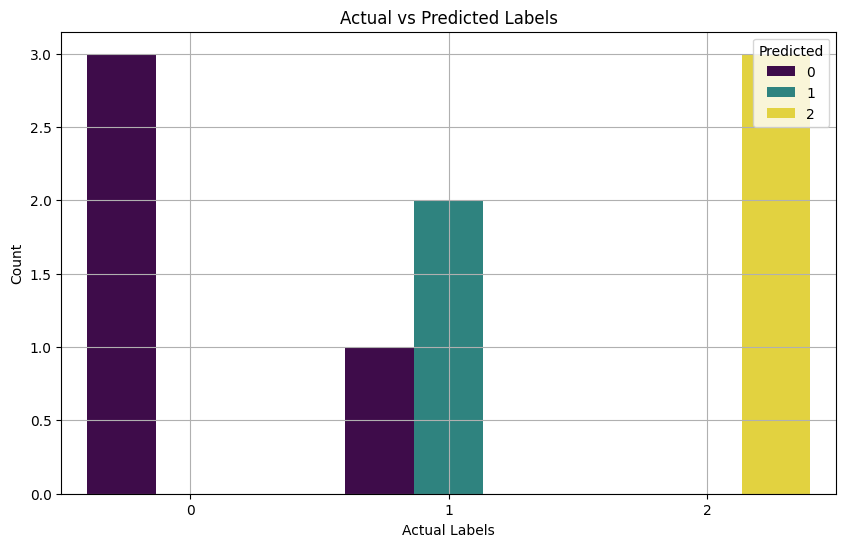

In [51]:
# Convert predictions and actual labels to numpy arrays for seaborn plotting
y_test_np = y_test.numpy()
predicted_np = predicted.numpy()

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({'Actual': y_test_np, 'Predicted': predicted_np})

# Plot the distribution of actual vs predicted labels
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df, x='Actual', hue='Predicted', palette='viridis')
plt.title('Actual vs Predicted Labels')
plt.xlabel('Actual Labels')
plt.ylabel('Count')
plt.legend(title='Predicted', loc='upper right')
plt.grid(True)
plt.show()
